### 1. Реализовать персональный топ  - принимает на вход гео и возраст, на выходе персональный топ   - 1 балл

Персональный топ - это топ товаров по похожим возрасту/интересам/локации. Как сделать? Разбить на сегменты по выбраным признакам. Топ делать по книгам с хорошим средним рейтингом.

In [ ]:
import numpy as np
import pandas as pd
import tqdm
import re
!pip install lightfm
from lightfm import LightFM
from io import BytesIO
from PIL import Image
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import gensim
from scipy.sparse import coo_matrix, csr_matrix
from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import pairwise_distances

     |████████████████████████████████| 317kB 9.3MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp36-cp36m-linux_x86_64.whl size=704271 sha256=3e0113fd761c233b9839cdc008aa6ad8696c5d4b1a5af5e7a651af5b64e52587
  Stored in directory: /root/.cache/pip/wheels/c6/64/d4/673c7277f71ac4c5ad4835b94708c01b653ef2d3aa78ef20aa
Successfully built lightfm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
books = pd.read_csv('/content/drive/MyDrive/data/BX-Books.csv')
users = pd.read_csv('/content/drive/MyDrive/data/BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')
ratings = pd.read_csv("/content/drive/MyDrive/data/BX-Book-Ratings.csv", sep=";", encoding = "ISO-8859-1")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [ ]:
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [ ]:
books.loc[books.ISBN == '0789466953','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '0789466953','Book-Author'] = "James Buckley"
books.loc[books.ISBN == '0789466953','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','Book-Title'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"
books.loc[books.ISBN == '078946697X','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '078946697X','Book-Author'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','Book-Title'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

In [ ]:
books.loc[(books.ISBN == '0789466953') | (books.ISBN == '078946697X'),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [ ]:
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


In [ ]:
books.loc[books['Book-Author'] == 'Jean-Marie Gustave Le ClÃ?Â©zio',['Book-Title']]

,Book-Title
100563,La Ronde et autres faits divers
178402,Printemps et Autres saisons
178429,Le Chercheur d'Or
178486,Etoile errante
178558,Diego et Frida
185000,Le ProcÃ?Â¨s-verbal


In [ ]:
books.loc[books.ISBN == '2070426769','Year-Of-Publication'] = 2003
books.loc[books.ISBN == '2070426769','Book-Author'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','Publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','Book-Title'] = "Peuple du ciel, suivi de 'Les Bergers"

In [ ]:
books.loc[books.ISBN == '2070426769',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


In [ ]:
books['Year-Of-Publication']=pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

In [ ]:
books.loc[(books['Year-Of-Publication'] > 2020) | (books['Year-Of-Publication'] == 0),'Year-Of-Publication'] = np.NAN
books['Year-Of-Publication'].fillna(round(books['Year-Of-Publication'].mean()), inplace=True)
books['Year-Of-Publication'] = books['Year-Of-Publication'].astype(np.int32)

In [ ]:
books['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 1968, 1961, 1958, 1974, 1976,
       1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960, 1966,
       1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954, 1950,
       1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011, 1925,
       1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 1911, 1904,
       1949, 1932, 1928, 1929, 1927, 1931, 1914, 1934, 1910, 1933, 1902,
       1924, 1921, 1900, 1944, 1917, 1901, 2010, 1908, 1906, 1935, 1806,
       2012, 2006, 1909, 2008, 1378, 1919, 1922, 1897, 1376], dtype=int32)

In [ ]:
books.loc[(books['Publisher'].isnull()),'Publisher'] = 'other'

In [ ]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
users['Age'].unique()

array([ nan,  18.,  17.,  61.,  26.,  14.,  25.,  19.,  46.,  55.,  32.,
        24.,  20.,  34.,  23.,  51.,  31.,  21.,  44.,  30.,  57.,  43.,
        37.,  41.,  54.,  42.,  50.,  39.,  53.,  47.,  36.,  28.,  35.,
        13.,  58.,  49.,  38.,  45.,  62.,  63.,  27.,  33.,  29.,  66.,
        40.,  15.,  60.,   0.,  79.,  22.,  16.,  65.,  59.,  48.,  72.,
        56.,  67.,   1.,  80.,  52.,  69.,  71.,  73.,  78.,   9.,  64.,
       103., 104.,  12.,  74.,  75., 231.,   3.,  76.,  83.,  68., 119.,
        11.,  77.,   2.,  70.,  93.,   8.,   7.,   4.,  81., 114., 230.,
       239.,  10.,   5., 148., 151.,   6., 101., 201.,  96.,  84.,  82.,
        90., 123., 244., 133.,  91., 128.,  94.,  85., 141., 110.,  97.,
       219.,  86., 124.,  92., 175., 172., 209., 212., 237.,  87., 162.,
       100., 156., 136.,  95.,  89., 106.,  99., 108., 210.,  88., 199.,
       147., 168., 132., 159., 186., 152., 102., 116., 200., 115., 226.,
       137., 207., 229., 138., 109., 105., 228., 18

In [ ]:
users.loc[(users['Age'] > 90) | (users['Age'] < 5), 'Age'] = np.nan
users.Age = users['Age'].fillna(users['Age'].mean())
users.Age = users['Age'].astype(np.int32)

In [ ]:
users.Age.unique()

array([34, 18, 17, 61, 26, 14, 25, 19, 46, 55, 32, 24, 20, 23, 51, 31, 21,
       44, 30, 57, 43, 37, 41, 54, 42, 50, 39, 53, 47, 36, 28, 35, 13, 58,
       49, 38, 45, 62, 63, 27, 33, 29, 66, 40, 15, 60, 79, 22, 16, 65, 59,
       48, 72, 56, 67, 80, 52, 69, 71, 73, 78,  9, 64, 12, 74, 75, 76, 83,
       68, 11, 77, 70,  8,  7, 81, 10,  5,  6, 84, 82, 90, 85, 86, 87, 89,
       88], dtype=int32)

In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
print(ratings.shape)
print(books.shape)
print(users.shape)

(1149780, 3)
(271360, 8)
(278858, 3)


In [ ]:
ratings = ratings[ratings['Book-Rating']!=0]

In [ ]:
ratings = ratings[ratings['ISBN'].isin(books['ISBN'])]

In [ ]:
ratings = ratings[ratings['User-ID'].isin(users['User-ID'])]

In [ ]:
users = users[users['User-ID'].isin(ratings['User-ID'])]

In [ ]:
books = books[books['ISBN'].isin(ratings['ISBN'])]

In [ ]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...,http://images.amazon.com/images/P/0425176428.0...


In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9


In [ ]:
users.head()

,User-ID,Location,Age
7,8,"timmins, ontario, canada",34
8,9,"germantown, tennessee, usa",34
11,12,"fort bragg, california, usa",34
13,14,"mediapolis, iowa, usa",34
15,16,"albuquerque, new mexico, usa",34


In [ ]:
len(users['User-ID'].unique())

68091

In [ ]:
len(ratings['User-ID'].unique())

68091

In [ ]:
books["ISBN"]

1         0002005018
2         0060973129
3         0374157065
5         0399135782
6         0425176428
             ...    
271346    0395264707
271352    1845170423
271354    0449906736
271355    0440400988
271356    0525447644
Name: ISBN, Length: 149836, dtype: object

In [ ]:
mainDF = ratings

In [ ]:
mainDF = mainDF.merge(books[["ISBN", "Book-Title", "Book-Author"]], on=["ISBN"])

In [ ]:
ratings.head()

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
8,276744,038550120X,7
16,276747,0060517794,9


In [ ]:
mainDF.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author
0,276726,0155061224,5,Rites of Passage,Judith Rae
1,276729,052165615X,3,Help!: Level 1,Philip Prowse
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather
3,276744,038550120X,7,A Painted House,JOHN GRISHAM
4,11676,038550120X,10,A Painted House,JOHN GRISHAM


In [ ]:
users.head()

,User-ID,Location,Age
7,8,"timmins, ontario, canada",34
8,9,"germantown, tennessee, usa",34
11,12,"fort bragg, california, usa",34
13,14,"mediapolis, iowa, usa",34
15,16,"albuquerque, new mexico, usa",34


In [ ]:
mainDF = mainDF.merge(users[["User-ID", "Location", "Age"]], on=["User-ID"])

In [ ]:
mainDF

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Location,Age
0,276726,0155061224,5,Rites of Passage,Judith Rae,"seattle, washington, usa",34
1,276729,052165615X,3,Help!: Level 1,Philip Prowse,"rijeka, n/a, croatia",16
2,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,"rijeka, n/a, croatia",16
3,276744,038550120X,7,A Painted House,JOHN GRISHAM,"torrance, california, usa",34
4,11676,038550120X,10,A Painted House,JOHN GRISHAM,"n/a, n/a, n/a",34
...,...,...,...,...,...,...,...
383837,276660,0583307841,8,ROBOT RACE (MICRO ADV 6),David Antony Kroft,"singapore, n/a, singapore",15
383838,276664,0004703723,9,Dictionary Of Economics-2Nd Ed,Christopher Pass,"daventry, england, united kingdom",31
383839,276664,0140136908,7,History of Economic Thought (Penguin Economics),William J. Barber,"daventry, england, united kingdom",31
383840,276664,0631189629,9,British Social Policy Since 1945 (Making Conte...,Howard Glennerster,"daventry, england, united kingdom",31


## Решил, что возвращать нужно максимальный рейтинг из отфильтрованного списка и еще те книги, которые на 3 оценки ниже, чтобы точно был "обширный" выбор

In [ ]:
def PersonalTopGeoAge(geo,age):
    bufDF = mainDF[((mainDF['Location'] == geo) | (mainDF['Age'] == age))]
    returnData = bufDF.sort_values("Book-Rating", ascending=False)
    returnData = returnData[((returnData['Book-Rating'])+3 >= returnData.iloc[1]["Book-Rating"])]
    return returnData
Top = PersonalTopGeoAge("rijeka, n/a, croatia",23)

In [ ]:
Top

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Location,Age
93299,15418,0316358398,10,Tintin in Tibet (The Adventures of Tintin),Herge,"vitoria, álava, spain",23
106381,71853,0767902890,10,The Things They Carried,TIM O'BRIEN,"somerville, massachusetts, usa",23
106260,56856,0684865742,10,Tis: A Memoir,Frank McCourt,"escondido, california, usa",23
334340,227539,3596130735,10,Der Drachenbeinthron.,Tad Williams,"tübingen, baden-wuerttemberg, germany",23
223254,66556,0822000946,10,Shakespeare's Twelfth Night (Cliffs Notes),James L. Roberts,"ventura, california, usa",23
...,...,...,...,...,...,...,...
50117,224349,0689804458,7,A String in the Harp,Nancy Bond,"columbia, maryland, usa",23
260596,78573,0590420275,7,Still More Tales for the Midnight Hour,J. B. Stamper,"easley, south carolina, usa",23
222569,133296,038081076X,7,All the Time in the World,Liz Nickles,"ormond beach, florida, usa",23
262882,205979,0330341634,7,The Daughters of Cain,Colin Dexter,"leeds, england, united kingdom",23


## 2. На основе метода кластеризации похожих пользователей построить рекомендации (Слайд 25) - 2 балла
Нужно топ-10 рекомендаций с самой высокой оценкой. Считаем среднюю оценку для каждой книги по кластеру и выводим топ-10 книг.

In [ ]:
userRatings = mainDF['User-ID'].value_counts()
bufDF = mainDF[mainDF['User-ID'].isin(userRatings[userRatings >= 100].index)]

In [ ]:
bufDF.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Location,Age
4,11676,038550120X,10,A Painted House,JOHN GRISHAM,"n/a, n/a, n/a",34
5,11676,0671537458,8,Waiting to Exhale,Terry McMillan,"n/a, n/a, n/a",34
6,11676,0679776818,8,Birdsong: A Novel of Love and War,Sebastian Faulks,"n/a, n/a, n/a",34
7,11676,0684867621,3,The Girl Who Loved Tom Gordon : A Novel,Stephen King,"n/a, n/a, n/a",34
8,11676,3499230933,1,Adressat unbekannt.,Kathrine Kressmann Taylor,"n/a, n/a, n/a",34


In [ ]:
ratings_matrix = bufDF.pivot(index='User-ID', columns='ISBN', values='Book-Rating')
userID = ratings_matrix.index
ISBN = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

(449, 66574)


ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,0001056107,0001845039,0001935968,0001944711,0001952803,0001953877,0002000547,0002005018,0002005050,0002005557,0002006588,0002115328,0002116286,0002118580,0002154900,0002158973,0002163713,0002176181,0002176432,0002179695,0002181924,0002184974,0002190915,0002197154,0002223929,0002228394,000223257X,0002233509,0002239183,0002240114,...,987960170X,9974643058,999058284X,9992003766,9992059958,9993584185,9994256963,9994348337,9997405137,9997406567,9997406990,999740923X,9997409728,9997411757,9997411870,9997412044,9997412958,9997507002,999750805X,9997508769,9997512952,9997519086,9997555635,9998914140,B00001U0CP,B00005TZWI,B00006CRTE,B00006I4OX,B00007FYKW,B00008RWPV,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
User-ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2033,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
ratings_matrix.fillna(0, inplace = True)
ratings_matrix = ratings_matrix.astype(np.int32)
ratings_matrix.head()

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,0001056107,0001845039,0001935968,0001944711,0001952803,0001953877,0002000547,0002005018,0002005050,0002005557,0002006588,0002115328,0002116286,0002118580,0002154900,0002158973,0002163713,0002176181,0002176432,0002179695,0002181924,0002184974,0002190915,0002197154,0002223929,0002228394,000223257X,0002233509,0002239183,0002240114,...,987960170X,9974643058,999058284X,9992003766,9992059958,9993584185,9994256963,9994348337,9997405137,9997406567,9997406990,999740923X,9997409728,9997411757,9997411870,9997412044,9997412958,9997507002,999750805X,9997508769,9997512952,9997519086,9997555635,9998914140,B00001U0CP,B00005TZWI,B00006CRTE,B00006I4OX,B00007FYKW,B00008RWPV,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
User-ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2110,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2276,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4017,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4385,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
ratings_matrix.loc[2033:2111]

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,0001056107,0001845039,0001935968,0001944711,0001952803,0001953877,0002000547,0002005018,0002005050,0002005557,0002006588,0002115328,0002116286,0002118580,0002154900,0002158973,0002163713,0002176181,0002176432,0002179695,0002181924,0002184974,0002190915,0002197154,0002223929,0002228394,000223257X,0002233509,0002239183,0002240114,...,987960170X,9974643058,999058284X,9992003766,9992059958,9993584185,9994256963,9994348337,9997405137,9997406567,9997406990,999740923X,9997409728,9997411757,9997411870,9997412044,9997412958,9997507002,999750805X,9997508769,9997512952,9997519086,9997555635,9998914140,B00001U0CP,B00005TZWI,B00006CRTE,B00006I4OX,B00007FYKW,B00008RWPV,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
User-ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2033,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2110,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
ratings_matrix.iloc[0]

ISBN
0000913154    0
0001046438    0
000104687X    0
0001047213    0
0001047973    0
             ..
B0000VZEJQ    0
B0000X8HIE    0
B00013AX9E    0
B0001I1KOG    0
B000234N3A    0
Name: 2033, Length: 66574, dtype: int32

In [ ]:

def findksimilarusers(user_id, ratings, metric = 'cosine', k=20):
    similarities=[]
    indices=[]
    model_knn = NearestNeighbors(metric = metric, algorithm = 'brute') 
    model_knn.fit(ratings)
    loc = ratings.index.get_loc(user_id)
    distances, indices = model_knn.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors = k+1)
    similarities = 1-distances.flatten()
   
    return similarities,indices

In [ ]:
mera, indx = findksimilarusers(2033,ratings_matrix)

In [ ]:
col = ratings_matrix.iloc[indx[0]].columns
col

Index(['0000913154', '0001046438', '000104687X', '0001047213', '0001047973',
       '000104799X', '0001048082', '0001053736', '0001053744', '0001055607',
       ...
       'B000092Q0A', 'B00009EF82', 'B00009NDAN', 'B0000DYXID', 'B0000T6KHI',
       'B0000VZEJQ', 'B0000X8HIE', 'B00013AX9E', 'B0001I1KOG', 'B000234N3A'],
      dtype='object', name='ISBN', length=66574)

In [ ]:
ratings_matrix.iloc[indx[0]][col[1]].mean()

0.0

In [ ]:
ratings_matrix.iloc[indx[0]].shape

(21, 66574)

In [ ]:
topcik = np.empty((2,66574),dtype=object)
topcik[0][1]="2424"
topcik

array([[None, '2424', None, ..., None, None, None],
       [None, None, None, ..., None, None, None]], dtype=object)

In [ ]:
indx[0][1]

70

In [ ]:
indx[0]

array([  0,  70, 420, 278, 362,  85,   2, 292,  48, 200, 109, 174, 221,
        92, 370, 117, 335, 388, 128,   7, 270])

In [ ]:
bbb = (ratings_matrix.iloc[indx[0]][col[422]]!=0).mean()
bbb

0.047619047619047616

In [ ]:
ratings_matrix.iloc[indx[0]][col[422]!=0].mean()

KeyError: ignored

In [ ]:
topcik = np.empty((2,66574),dtype=object)
for i in  tqdm.tqdm_notebook(range(66574)):
  topcik[0][i] = ratings_matrix.iloc[indx[0]][col[i]].mean()
  if np.isnan(topcik[0][i]):
    topcik[0][i] = 0
  topcik[1][i] = col[i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


KeyboardInterrupt: ignored

In [ ]:
sortInd = (topcik[0]).argsort()
sortInd

array([    0, 43898, 43899, ..., 54175, 54173, 20672])

In [ ]:
topTen = []
for i in range(len(sortInd)-1,len(sortInd)-1-10,-1):
  topTen.append(sortInd[i])
topTen

[20672, 54173, 54175, 38529, 54179, 54182, 38535, 49587, 54183, 54185]

In [ ]:
for i in range(10):
  print(topcik[0][topTen[i]], topcik[1][topTen[i]])

10.0 0394837037
10.0 0886773121
10.0 0886773199
10.0 0671720996
10.0 0886773245
10.0 0886773490
10.0 0671721178
10.0 0812574990
10.0 0886773520
10.0 0886773555


In [ ]:
def predict_userbased(user_id, ratings, metric = 'cosine', k=20):
    user_loc = ratings.index.get_loc(user_id)
    similarities, indices=findksimilarusers(user_id, ratings,metric, k) 
    basedUserDF = ratings.iloc[indices[0]]
    col = ratings.iloc[indices[0]].columns
    topcik = np.empty((2,66574),dtype=object)
    for i in  tqdm.tqdm_notebook(range(66574)):
      topcik[0][i] = ratings.iloc[indices[0]][col[i]].mean()
      topcik[1][i] = col[i]
    sortInd = (topcik[0]).argsort()
    topTen = []
    for i in range(len(sortInd)-1,len(sortInd)-1-10,-1):
      topTen.append(sortInd[i])
    print("Для пользователя {user_id}, судя по похожим пользователям, подходит следующий топ 10: ")
    for i in range(10):
      print(f"Рейтинг по похожим пользователям: {topcik[0][topTen[i]]}; ISBN ID книги: {topcik[1][topTen[i]]}")

In [ ]:
predict_userbased(11676,ratings_matrix)

ValueError: ignored

3. Применить методы расмотренные на лекции (Совстречаемость - 2 балл, Content-based - 1 балл, Коллаборативная фильтрация - 3 балла , Матричная Факторизация - 1 балл) - 7 баллов
В совстречаемости также учитывать оценки. Вес пары книг встретившихся у пользователя - полусумма их оценок

Коллаборативную фильтрацию реализовывать как на слайде 50 презентации, посоветовав каждому пользователю топ-10 книг с самой высокой оценкой. Сделать рекомендации User-based и Item-based и сравнить.

Если совсем сложно - можно сделать как в семинарской части, поставив оценку "0", если рейтинг < 5 и "1" - в противном случае. Тогда максимум за это - 1 балл.

Для Content-based, Коллаборативной фильтрации, Матричной Факторизации реализовать U2I и I2I рекомендации

Примечание:
Так как пользователей много - можно зафиксировать несколько произвольных и для них уже составлять рекомендации Работоспособность I2I можно проверять на известных книгах (Гарри Поттер, Властелин Колец, Интервью с вампиром, Код-Да-Винчи, Маленький Принц) Рейтинг книг обязательно нужно учитывать

In [ ]:
interactions = ratings

In [ ]:
books_meets = interactions.groupby("ISBN")["User-ID"].count().reset_index().rename(columns={"User-ID": "user_num"})

In [ ]:
user_meets = interactions.groupby("User-ID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})

In [ ]:
interactions = interactions.merge(books_meets, on=["ISBN"]).merge(user_meets, on=["User-ID"])

In [ ]:
interactions = interactions[(interactions["user_num"] > 5) & 
                            (interactions["books_num"] > 5) &
                            (interactions["books_num"] < 200)]

In [ ]:
interactions = interactions.merge(books[["ISBN", "Image-URL-M", "Book-Title"]].rename(
    columns={"Image-URL-M": "picture_url"}), on=["ISBN"])

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
interactions["product_id"] = le.fit_transform(interactions["ISBN"])
interactions["vid"] = le.fit_transform(interactions["User-ID"])

In [ ]:
interactions

,User-ID,ISBN,Book-Rating,user_num,books_num,picture_url,Book-Title,product_id,vid
0,16877,038550120X,9,81,10,http://images.amazon.com/images/P/038550120X.0...,A Painted House,3451,560
1,21356,038550120X,7,81,24,http://images.amazon.com/images/P/038550120X.0...,A Painted House,3451,717
2,22625,038550120X,10,81,97,http://images.amazon.com/images/P/038550120X.0...,A Painted House,3451,765
3,29168,038550120X,7,81,6,http://images.amazon.com/images/P/038550120X.0...,A Painted House,3451,1037
4,32188,038550120X,8,81,12,http://images.amazon.com/images/P/038550120X.0...,A Painted House,3451,1194
...,...,...,...,...,...,...,...,...,...
110056,145000,3250600555,8,9,6,http://images.amazon.com/images/P/3250600555.0...,Monsieur Ibrahim und die Blumen des Koran. Erz...,10347,5433
110057,152401,3250600555,9,9,10,http://images.amazon.com/images/P/3250600555.0...,Monsieur Ibrahim und die Blumen des Koran. Erz...,10347,5680
110058,67785,0140119205,7,6,9,http://images.amazon.com/images/P/0140119205.0...,Nice Work,865,2535
110059,223525,1588720284,8,6,13,http://images.amazon.com/images/P/1588720284.0...,Why Your Life Sucks: And What You Can Do Abou...,10135,8213


In [ ]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def rec_imaging(product_ids, content_dict, measure=None, top_n=1):
    picture_title = [content_dict[i] for i in product_ids]
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_title, top_n)):
        fig = plt.figure(figsize=(0.1,0.1))
        for n, i in enumerate(chunk):
          print(i)
          a = fig.add_subplot(1, top_n, n + 1)
          if measure is not None:
            a.title.set_text("measure = {}".format(np.round(measure[cnt], 4)))
          cnt += 1
          plt.axis('off')
        plt.show()

## Совстречаемость

In [ ]:
class Recomendations():
    def __init__(self, Int):
        self.product_id_to_title = {}
        for i in Int[["product_id", "Book-Title"]].drop_duplicates().values:
            self.product_id_to_title[i[0]] = i[1]
        self.interactions = Int
        
    def coocurrency_count(self):
        Int = self.interactions[["vid", "product_id"]].drop_duplicates()
        user_products = Int.groupby(["vid"])["product_id"].apply(list).reset_index()
        product_num = [len(i) for i in user_products["product_id"]]
        user_products["prod_num"] = product_num
        user_products = user_products[user_products["prod_num"] > 1]
        
        cooc = {}
        for i in tqdm.tqdm_notebook(user_products.values):
            for j in range(len(i[1])):
                for k in range(len(i[1])):
                    if j != k:
                        try:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] += 1
                        except:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] = 1
        cooc_list = []
        for i, j in cooc.items():
            if j != 1:
                cooc_list.append(i.split("_") + [j])
        self.cooc_rec = pd.DataFrame(cooc_list, columns=["item1", "item2", "measure"])
    
    def get_rec(self, i, show=False):
        recs = self.cooc_rec[self.cooc_rec["item1"] == str(i)]\
                            .sort_values("measure", ascending=False)\
                            .head(10)
        print(u"Для товара")
        rec_imaging([i], self.product_id_to_title)
        print(u"Такие рекомендации")
        rec_imaging(recs["item2"].values.astype(int), self.product_id_to_title, 
                         recs["measure"].values.astype(int))

In [ ]:
cooc_rec = Recomendations(interactions)
cooc_rec.coocurrency_count()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


Для товара
Prince Caspian


Такие рекомендации
Lion, the Witch and the Wardrobe


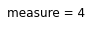

Horse and His Boy


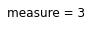

The Silver Chair


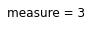

The Last Battle (The Chronicles of Narnia Book 7)


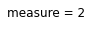

Anne of Green Gables (Anne of Green Gables Novels (Paperback))


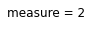

Politically Correct Bedtime Stories: Modern Tales for Our Life and Times


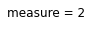

Round Ireland With a Fridge


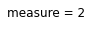

Voyage of the Dawn Treader


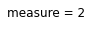

In [ ]:
cooc_rec.get_rec(32)

## Content-based

In [ ]:
class Content_Based():
    def __init__(self, items, interactions):
        self.items = items
        self.interactions = interactions
        self.content_dict = {}
        for i, j in enumerate(items["Book-Title"]):
            self.content_dict[i] = j
        self.inversed_dict = {v: k for k, v in self.content_dict.items()}
        
    def avg_feature_vector(self, words, model, num_features, index2word_set):
        feature_vec = np.zeros((num_features, ), dtype='float32')
        n_words = 0
        for word in words:
            if word in index2word_set:
                n_words += 1
                feature_vec = np.add(feature_vec, model.wv[word])
        if (n_words > 0):
            feature_vec = feature_vec / n_words
        return feature_vec

    def get_items_representation(self):
        
        item_description = [gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", i.lower())) 
                            for i in self.items['Book-Title']]
        self.model = gensim.models.Word2Vec(
                item_description,
                size=200,
                window=10,
                min_count=1,
                workers=10,
                iter=100)
        self.index2word_set = set(self.model.wv.index2word)
        self.items_embs = np.zeros((len(item_description), 200))
        for i in range(self.items_embs.shape[0]):
            self.items_embs[i] = self.avg_feature_vector(item_description[i], self.model, 200, self.index2word_set)
        
        
    def get_rec_I2I(self, i):
        metrics = cosine_similarity([self.items_embs[i]], self.items_embs)
        print(u"Для товара")
        rec_imaging([i], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(metrics)[0][::-1][1:11], self.content_dict, np.sort(metrics)[0][::-1][1:11])


    def get_rec_U2I(self, i):
        ui = self.interactions[self.interactions["vid"] == i]
        user_vector = " ".join(ui["Book-Title"])
        user_processed = gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", user_vector.lower()))
        user_emb = self.avg_feature_vector(user_processed, self.model, 200, self.index2word_set)
        metrics = cosine_similarity([user_emb], self.items_embs)
        print(u"Для пользователя, который взаимодействовал с товарами")
        rec_imaging(np.unique([self.inversed_dict[i] for i in ui["Book-Title"]]), self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(metrics)[0][::-1][1:11], self.content_dict, np.sort(metrics)[0][::-1][1:11])

In [ ]:
CB = Content_Based(books, interactions)

In [ ]:
CB.get_items_representation()

## I2I

Для товара
Flood : Mississippi 1927


Такие рекомендации
FLOOD : Mississippi 1927


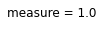

Mississippi Raider


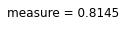

Spelling Mississippi


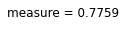

JOHNSTOWN FLOOD


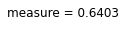

Flood


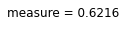

Flood


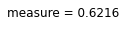

Mississippi Solo


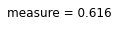

Manhunting in Mississippi


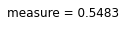

Flood Tide


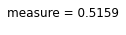

FLOOD TIDE


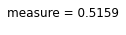

In [ ]:
CB.get_rec_I2I(21)

## U2I

Для пользователя, который взаимодействовал с товарами
The Lovely Bones: A Novel


The Music of Dolphins (Apple Signature Edition)


The Magician's Nephew (Narnia)


Deep Wizardry: The Second Book in the Young Wizards Series


The Giver (21st Century Reference)


The Hitchhiker's Guide to the Galaxy


So You Want to Be a Wizard: The First Book in the Young Wizards Series


Такие рекомендации
The Wizard's Dilemma: The Fifth Book in the Young Wizards Series


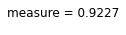

The Wizard's Holiday: The Seventh Book in the Young Wizards Series


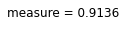

Sorcerers of the Nightwing (The Ravenscliff Series, Book 1)


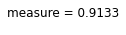

The Book of the Goons


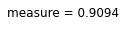

The Book of the Penis


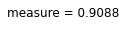

Deep Wizardry: The Second Book in the Young Wizards Series


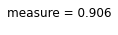

The Book of Perfumes


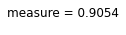

The Seeress of Kell (The Malloreon, Book 5)


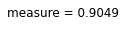

The Book of Nod


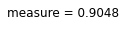

The Book of Disquiet


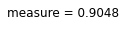

In [ ]:
CB.get_rec_U2I(21)

## Матричная Факторизация

In [ ]:
class MatrixFactorization():
    
    def __init__(self, inter, k):
        inter["product_id"] = inter["product_id"].astype(int)
        self.k = k
        self.content_dict = {}
        for i, j in inter[["product_id", "Book-Title"]].drop_duplicates().values:
          self.content_dict[i] = j
        self.csr_rates = coo_matrix((interactions["Book-Rating"], (interactions["vid"], interactions["product_id"])), 
                            shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))
        
    def MF(self):
        U, S, V = svds(self.csr_rates.astype(float), k=self.k)
        self.user_embs = U
        self.items_embs = V.T
        
    def LightFM(self):
        self.model = LightFM(loss='warp', no_components=100, learning_rate=0.03, learning_schedule="adadelta")
        self.model.fit(self.csr_rates, epochs=5, num_threads=40, verbose=True)
        self.user_feature_bias, self.user_feature_embeddings = self.model.get_user_representations()
        self.item_feature_bias, self.items_embs = self.model.get_item_representations()

    def get_rec_I2I(self, i):
        metrics = cosine_similarity([self.items_embs[i]], self.items_embs)
        print(u"Для товара")
        rec_imaging([i], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(metrics)[0][::-1][1:11], self.content_dict, np.sort(metrics)[0][::-1][1:11])

    def avg_feature_vector(Int, words, model, num_features, index2word_set):
        feature_vec = np.zeros((num_features, ), dtype='float32')
        n_words = 0
        for word in words:
            if word in index2word_set:
                n_words += 1
                feature_vec = np.add(feature_vec, model.wv[word])
        if (n_words > 0):
            feature_vec = feature_vec / n_words
        return feature_vec

In [ ]:
simple_svd = MatrixFactorization(interactions, 30)
simple_svd.MF()

In [ ]:
mf = MatrixFactorization(interactions, 300)
mf.LightFM()

Epoch: 100%|██████████| 5/5 [00:03<00:00,  1.43it/s]


Для товара
Dirt: A Novel


Такие рекомендации
TEARS OF RAGE


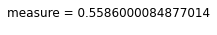

Missing Pieces


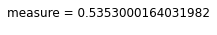

Spandau Phoenix


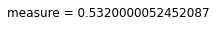

A Certain Justice (Adam Dalgliesh Mysteries (Hardcover))


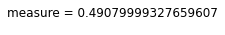

Night Prey


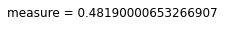

Vanishing Act (Jane Whitfield Novel)


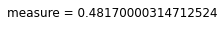

Orchid Blues (Holly Barker Novels (Hardcover))


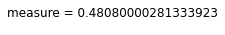

Hide and Seek


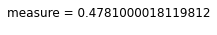

The BIBLE CODE


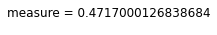

Jack and Jill: A Novel


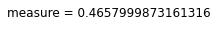

In [ ]:
mf.get_rec_I2I(123)

## Коллаборативная фильтрация

In [ ]:
class Colloborative():
    def __init__(self, interactions):
        interactions["product_id"] = interactions["product_id"].astype(int)
        self.content_dict = {}
        for i, j in interactions[["product_id", "Book-Title"]].drop_duplicates().values:
          self.content_dict[i] = j
        self.csr_rates = coo_matrix((interactions["Book-Rating"], (interactions["vid"], interactions["product_id"])), 
                            shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))
        
    def user_based(self, idx):
        user_rates = self.csr_rates.getrow(idx).toarray()[0]
        watched_items = np.where(user_rates != 0)[0]
        metrics = cosine_similarity([user_rates], self.csr_rates).reshape(-1, 1)
        rates = csr_matrix.multiply(self.csr_rates.copy(), metrics)
        total_rate = (1 - user_rates.astype(bool)) * np.array(np.sum(rates, axis=0))[0]
        self.get_rec(watched_items, np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                    np.sort(total_rate)[::-1][:10],1)
        
    def item_based(self, idx):
        item_rates = self.csr_rates.getcol(idx).toarray().reshape(1, -1)
        metrics = cosine_similarity(item_rates, self.csr_rates.T).reshape(-1, 1)
        rates = csr_matrix.multiply(self.csr_rates.T.copy(), metrics)
        total_rate = np.array(np.sum(rates, axis=1)).ravel()
        self.get_rec([idx], np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                    np.sort(total_rate)[::-1][:10],2)

    def get_rec(self, watched, recs, measure, key):
      if key == 2:
        print(u"Для такого товара")
        rec_imaging([i for i in watched], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging([i for i in recs], self.content_dict, measure)
      if key == 1:
        print(u"Для пользователя, которому понравились эти товары")
        rec_imaging([i for i in watched], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging([i for i in recs], self.content_dict, measure)

In [ ]:
clb = Colloborative(interactions)

## U2I

Для пользователя, которому понравились эти товары
The Nanny Diaries: A Novel


Mad Cows


Malice


Silent Honor


Journey


The House on Hope Street


Secrets


Heartbeat


Nights in Rodanthe


A Walk to Remember


Her Daughter's Eyes


Sula


Dance upon the Air (Three Sisters Island Trilogy)


A Is for Alibi (Kinsey Millhone Mysteries (Paperback))


Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))


He Sees You When You're Sleeping : A Novel


Salem Falls


Build A Better Life By Stealing Office Supplies


Book Club


Такие рекомендации
Harry Potter and the Chamber of Secrets (Book 2)


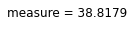

The Lovely Bones: A Novel


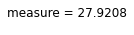

Harry Potter and the Prisoner of Azkaban (Book 3)


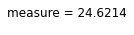

Harry Potter and the Order of the Phoenix (Book 5)


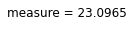

Harry Potter and the Goblet of Fire (Book 4)


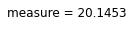

The Da Vinci Code


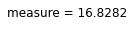

Harry Potter and the Prisoner of Azkaban (Book 3)


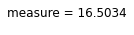

Harry Potter and the Goblet of Fire (Book 4)


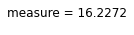

Divine Secrets of the Ya-Ya Sisterhood: A Novel


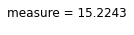

Face the Fire (Three Sisters Island Trilogy)


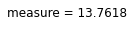

In [ ]:
clb.user_based(323)

## I2I

Для такого товара
The Masters of Deception : Gang That Ruled Cyberspace, The


Такие рекомендации
The Da Vinci Code


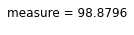

The Lovely Bones: A Novel


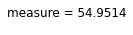

Timeline


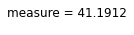

The Masters of Deception : Gang That Ruled Cyberspace, The


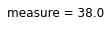

Mr. Murder


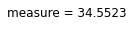

Lies and the Lying Liars Who Tell Them: A Fair and Balanced Look at the Right


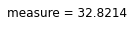

The Talisman


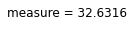

Dreamcatcher


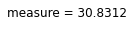

A Darkness More Than Night


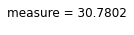

The Big Bad Wolf: A Novel


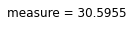

In [ ]:
clb.item_based(323)
